In [1]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, average_precision_score, classification_report, roc_auc_score
import numpy as np
import timm
import random


# Model Configration

In [2]:
# Configuration and Hyperparameters
data_dir = "/user/HS402/rk01219/Downloads/Classification/archive/MRI Dataset"  # Change to your data path
categories = ["no_tumor", "Glioma", "Meningioma", "Pituitary"]  # Include all brain tumor types
batch_size = 32
num_epochs = 100
learning_rate = 0.0007
model_name = 'resnet50' # 'vit', 'resnet50', 'resnet152', 'densenet121', 'deit'
optimizer_name = 'adam'  # Choose from ['adam', 'sgd']
freeze_pretrained = True  # Whether to freeze pretrained layers

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
   
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically with a probability of 0.5
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly shift the image height and width by up to 10%
    
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize the image with a scale range of 0.8 to 1.0
    transforms.RandomAdjustSharpness(1.85),  # Randomly adjust the sharpness by a factor of 1.85
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize the image with mean 0.485 and std 0.229
])

# Test transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize the image with mean 0.485 and std 0.229
])




# Paths to your datasets
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")


# Data Loading

Number of training images: 8000
Number of validation images: 1000
Number of test images: 1000
Visualizing random training images...


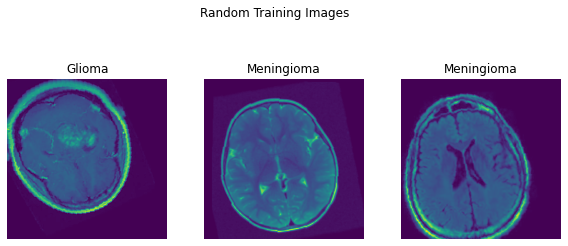

Visualizing random validation images...


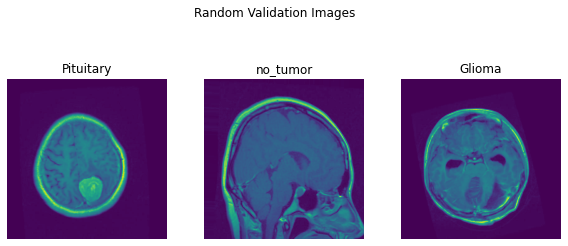

Visualizing random test images...


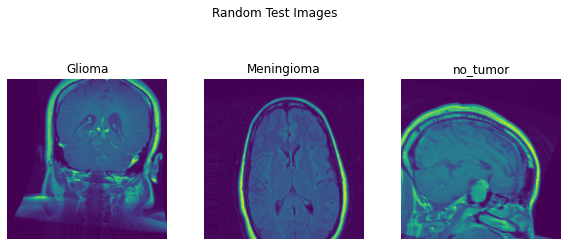

In [3]:
def load_data(directory):
    file_paths, labels = [], []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for file in os.listdir(label_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(label_dir, file))
                labels.append(label)
    return file_paths, labels

# Load train, validation, and test data
train_file_paths, train_labels = load_data(train_dir)
val_file_paths, val_labels = load_data(val_dir)
test_file_paths, test_labels = load_data(test_dir)

# Create DataFrames
train_df = pd.DataFrame({'file_path': train_file_paths, 'label': train_labels})
val_df = pd.DataFrame({'file_path': val_file_paths, 'label': val_labels})
test_df = pd.DataFrame({'file_path': test_file_paths, 'label': test_labels})

# Map labels to integers
label_map = {label: idx for idx, label in enumerate(train_df['label'].unique())}
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("L")  # Convert image to grayscale
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets and dataloaders
train_dataset = BrainTumorDataset(train_df, transform=transform)
val_dataset = BrainTumorDataset(val_df, transform=test_transform)
test_dataset = BrainTumorDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print the number of images in each set
print(f"Number of training images: {len(train_df)}")
print(f"Number of validation images: {len(val_df)}")
print(f"Number of test images: {len(test_df)}")

def show_random_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]
        plt.imshow(image.permute(1, 2, 0))
        plt.title(categories[label])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Visualizing random training images...")
show_random_images(train_dataset, 'Random Training Images')

print("Visualizing random validation images...")
show_random_images(val_dataset, 'Random Validation Images')

print("Visualizing random test images...")
show_random_images(test_dataset, 'Random Test Images')


In [4]:
import torch
import torch.nn as nn
from torchvision import models
import timm

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define categories - ensure this is defined somewhere in your script
categories = ['no_tumor', 'Glioma', 'Meningioma', 'Pituitary']

def build_vit_model(model_name='vit_base_patch16_224', num_classes=len(categories), pretrained=True, freeze=True):
    model = timm.create_model(model_name, pretrained=pretrained)
    if hasattr(model, 'patch_embed'):
        model.patch_embed.proj = nn.Conv2d(1, model.patch_embed.proj.out_channels, kernel_size=model.patch_embed.proj.kernel_size, stride=model.patch_embed.proj.stride, padding=model.patch_embed.proj.padding)
    else:
        raise ValueError("The model does not have a patch embedding layer.")
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.head.in_features
    model.head = nn.Linear(num_features, num_classes)
    return model.to(device)

def build_resnet50_model(num_classes=len(categories), pretrained=True, freeze=True):
    model = models.resnet50(pretrained=pretrained)
    model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model.to(device)

def build_resnet152_model(num_classes=len(categories), pretrained=True, freeze=True):
    model = models.resnet152(pretrained=pretrained)
    model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=False)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model.to(device)

def build_densenet121_model(num_classes=len(categories), pretrained=True, freeze=True):
    model = models.densenet121(pretrained=pretrained)
    model.features.conv0 = nn.Conv2d(1, model.features.conv0.out_channels, kernel_size=model.features.conv0.kernel_size, stride=model.features.conv0.stride, padding=model.features.conv0.padding, bias=False)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    return model.to(device)

def build_deit_model(model_name='deit_base_patch16_224', num_classes=len(categories), pretrained=True, freeze=True):
    model = timm.create_model(model_name, pretrained=pretrained)
    model.patch_embed.proj = nn.Conv2d(1, model.patch_embed.proj.out_channels, kernel_size=model.patch_embed.proj.kernel_size, stride=model.patch_embed.proj.stride, padding=model.patch_embed.proj.padding)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.head.in_features
    model.head = nn.Linear(num_features, num_classes)
    return model.to(device)

def select_model(model_name):
    if model_name == 'vit':
        print("Building Vision Transformer (ViT) model...")
        return build_vit_model(pretrained=True, freeze=True)
    elif model_name == 'resnet50':
        print("Building ResNet50 model...")
        return build_resnet50_model(pretrained=True, freeze=True)
    elif model_name == 'resnet152':
        print("Building ResNet152 model...")
        return build_resnet152_model(pretrained=True, freeze=True)
    elif model_name == 'densenet121':
        print("Building DenseNet121 model...")
        return build_densenet121_model(pretrained=True, freeze=True)
    elif model_name == 'deit':
        print("Building Data-efficient Image Transformer (DEiT) model...")
        return build_deit_model(pretrained=True, freeze=True)
    else:
        raise ValueError("Invalid model name. Choose from 'vit', 'resnet50', 'resnet152', 'densenet121', 'deit'.")


model = select_model(model_name)


Building ResNet50 model...


/user/HS402/rk01219/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/HS402/rk01219/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Optimizer

In [5]:
def select_optimizer(optimizer_name, model_parameters, lr):
    if optimizer_name == 'adam':
        print("Using Adam optimizer...")
        return optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'sgd':
        print("Using SGD optimizer...")
        return optim.SGD(model_parameters, lr=lr, momentum=0.9)
    else:
        raise ValueError("Invalid optimizer name. Choose from 'adam', 'sgd'.")

optimizer = select_optimizer(optimizer_name, model.parameters(), learning_rate)


Using Adam optimizer...


# Metrics

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

def calculate_metrics(labels, preds, probs, num_classes):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    if num_classes > 2:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr')
    else:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    mAP = average_precision_score(labels, probs, average='weighted')
    return accuracy, f1, roc_auc, mAP

def train_model(model, train_loader, val_loader, num_epochs, optimizer, num_classes):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    best_val_loss = np.inf

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_train_probs = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())
            all_train_probs.extend(probs.detach().cpu().numpy())

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        train_accuracy, train_f1, train_roc_auc, train_map = calculate_metrics(all_train_labels, all_train_preds, np.array(all_train_probs), num_classes)

        model.eval()
        val_loss = 0.0
        all_val_labels = []
        all_val_preds = []
        all_val_probs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        val_accuracy, val_f1, val_roc_auc, val_map = calculate_metrics(all_val_labels, all_val_preds, np.array(all_val_probs), num_classes)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, Train mAP: {train_map:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val mAP: {val_map:.4f}')

        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'VIT.pth')

    # Plot training and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


# Evaluation function

In [7]:

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy, f1, roc_auc, mAP = calculate_metrics(all_labels, all_preds, np.array(all_probs), num_classes)
    class_report = classification_report(all_labels, all_preds, target_names=categories)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')
    print(f'Test mAP: {mAP:.4f}')
    print('Classification Report:')
    print(class_report)
    
    return all_labels, all_preds, all_probs, cm, roc_auc, mAP

def plot_roc_curve(y_true, y_probs, classes):
    plt.figure()
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


# Training and Evaluation

Training RESNET50 model with ADAM optimizer...
Epoch 1/100, Train Loss: 0.8801, Train Acc: 0.6530, Train F1: 0.6497, Train mAP: 0.7090, Val Loss: 0.6881, Val Acc: 0.7330, Val F1: 0.7280, Val mAP: 0.8174
Epoch 2/100, Train Loss: 0.7097, Train Acc: 0.7244, Train F1: 0.7231, Train mAP: 0.7896, Val Loss: 0.5690, Val Acc: 0.7890, Val F1: 0.7896, Val mAP: 0.8614
Epoch 3/100, Train Loss: 0.6507, Train Acc: 0.7471, Train F1: 0.7467, Train mAP: 0.8167, Val Loss: 0.5478, Val Acc: 0.7920, Val F1: 0.7921, Val mAP: 0.8707
Epoch 4/100, Train Loss: 0.6385, Train Acc: 0.7511, Train F1: 0.7504, Train mAP: 0.8239, Val Loss: 0.5790, Val Acc: 0.7880, Val F1: 0.7904, Val mAP: 0.8696
Epoch 5/100, Train Loss: 0.6175, Train Acc: 0.7609, Train F1: 0.7599, Train mAP: 0.8338, Val Loss: 0.5109, Val Acc: 0.8100, Val F1: 0.8089, Val mAP: 0.8819
Epoch 6/100, Train Loss: 0.6073, Train Acc: 0.7682, Train F1: 0.7677, Train mAP: 0.8416, Val Loss: 0.5890, Val Acc: 0.7750, Val F1: 0.7711, Val mAP: 0.8773
Epoch 7/100, Trai

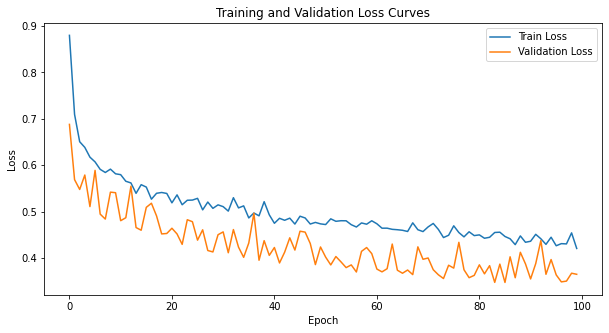

In [8]:
# Train the model
print(f"Training {model_name.upper()} model with {optimizer_name.upper()} optimizer...")
train_model(model, train_loader, val_loader, num_epochs, optimizer, len(categories))

Evaluating RESNET50 model...
Test Accuracy: 0.8490
Test F1 Score: 0.8472
Test ROC AUC: 0.9711
Test mAP: 0.9292
Classification Report:
              precision    recall  f1-score   support

    no_tumor       0.89      0.88      0.89       250
      Glioma       0.80      0.89      0.84       250
  Meningioma       0.88      0.92      0.90       250
   Pituitary       0.82      0.70      0.75       250

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



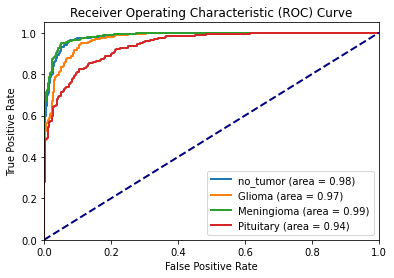

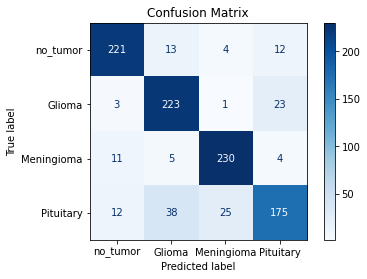

In [9]:
# Evaluate the model
print(f"Evaluating {model_name.upper()} model...")
model.load_state_dict(torch.load('VIT.pth'))
all_labels, all_preds, all_probs, cm, roc_auc, mAP = evaluate_model(model, test_loader, len(categories))
plot_roc_curve(np.array(all_labels), np.array(all_probs), categories)
plot_confusion_matrix(all_labels, all_preds, categories)
